# Text Mining - Análise de Sentimentos dos Reviews da Amazon
### René Porto e Ricardo Rolim

### Importar ficheiros

In [87]:
import os
import pandas as pd
import numpy as np
import nltk
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
from textblob import TextBlob

import sklearn.metrics as metrics

In [2]:
df = pd.read_csv("../TM/data/en-sentiment/amazon_reviews_train.csv", encoding="utf-8")
df_test = pd.read_csv("../TM/data/en-sentiment/amazon_reviews_test.csv", encoding="utf-8")
df.sample(5)

,sentiment,review
26898,negative,I bought these after reading the reviews. Wel...
22050,positive,I shopped by price and this was far and away t...
8087,positive,"Leibniz cookies are truly my favorite, beyond ..."
44280,positive,We bought these chips at a little sandwich sho...
27925,positive,I consider myself something of a chocolate con...


### Funções

In [3]:
# https://medium.com/@jorlugaqui/how-to-strip-html-tags-from-a-string-in-python-7cb81a2bbf44

def remover_tag_html(text):
    """Function that removes html tags"""
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

In [4]:
help(remover_tag_html)

Help on function remover_tag_html in module __main__:

remover_tag_html(text)
    Function that removes html tags



In [5]:
def plot_Cloud(wordCloud, name):
    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordCloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    name = name + ".png"
    plt.savefig(name, facecolor='k', bbox_inches='tight')

In [6]:
def stemming(tokens):
    ps=PorterStemmer()
    stem_words=[]
    for x in tokens:
        stem_words.append(ps.stem(x))
    return stem_words

In [7]:
def create_bag_Word_Corpus(df, column_name):
    words_corpus = []
    for val in df[column_name]:
        text = remover_tag_html(val)
        text = text.lower()
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word not in string.punctuation]
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        tokens = stemming(tokens)
        words_corpus.append(tokens)
    return words_corpus

In [8]:
def summary_dataset(df, df_test):
    count_pos_train = df.loc[df.sentiment=='positive', 'sentiment'].count()
    count_neg_train = df.loc[df.sentiment=='negative', 'sentiment'].count()
    count_pos_test = df_test.loc[df_test.sentiment=='positive', 'sentiment'].count()
    count_neg_test = df_test.loc[df_test.sentiment=='negative', 'sentiment'].count()
    total_train = len(df)
    total_test = len(df_test)
    total = total_train + total_test
    print(f"Treino (positivo): {count_pos_train} - {round(100 * count_pos_train / total_train,2)}% \
          \nTreino (negativo): {count_neg_train} - {round(100 * count_neg_train / total_train,2)}% \
          \nTotal Treino: {total_train} - {round(100 * total_train / total,2)}% \
          \n \
          \nTeste (positivo): {count_pos_test} - {round(100 * count_pos_test / total_test,2)}% \
          \nTeste (negativo): {count_neg_test} - {round(100 * count_neg_test / total_test,2)}% \
          \nTotal Teste: {total_test} - {round(100 * total_test / total,2)}% \
          \n \
          \nTotal: {total}")

In [9]:
#https://stackoverflow.com/questions/43485469/apply-textblob-in-for-each-row-of-a-dataframe
#https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html

# Decidimos usar o ZERO como review positivo

def sentiment_calc(text):
    try:
        sentiment_binary = 'negative' if TextBlob(text).sentiment.polarity < 0 else 'positive'
        return sentiment_binary
    except:
        return None

In [46]:
def sentiment_to_binary_n(sentiment):
    try:
        sentiment_to_binary_n = 1 if sentiment == 'positive' else 0
        return sentiment_to_binary_n
    except:
        return None

In [10]:
def sentiment_lex(df, column, blindneg):
    sentiment_lex = []
    for x in df[column]:
        result = ''
        sentiment_score = sum(lex[i] for i in x if i in lex)
        result = 'positive' if sentiment_score >= 0 else 'negative'
        if blindneg is True:
            #result = 'negative' if any(elem in x for elem in ["not", "n't"])
            if any(elem in x for elem in ["not", "n't"]):
                result = 'negative'
        sentiment_lex.append(result)
    return sentiment_lex

In [11]:
#https://medium.com/analytics-vidhya/sentiment-analysis-movies-reviews-b299de4bb1aa
def plot_confusion_matrix_accurancy(col_pred, col_actual):
    cm = confusion_matrix(df[col_pred], df[col_actual], labels=['positive', 'negative'])
    
    plt.figure(figsize = (5,5))
    sns.heatmap(cm,cmap= "Blues", 
                linecolor = 'black', 
                linewidth = 1, 
                annot = True, 
                fmt='', 
                xticklabels = ['Negative','Positive'], 
                yticklabels = ['Negative','Positive'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    score = accuracy_score(df[col_pred], df[col_actual])
    return print("accuracy:   %0.3f" % score)

In [71]:
#https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.Yj-znufP2Mo
def tfidf(df, column):
    tfidf.tfidf_vectorizer=TfidfVectorizer(use_idf=True)
    tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(df[column])
    return tfidf_vectorizer_vectors

In [77]:
def relatorio_modelo(df, column, y_pred, dim):
    print("Pontos rotulados incorretamente: %d de %d"% ((df[column]!=y_pred).sum(), dim))
    print("Accuracy: ", metrics.accuracy_score(df[column], y_pred))
    print("Precision: ", metrics.precision_score(df[column], y_pred, average="macro"))
    print("Recall: ", metrics.recall_score(df[column], y_pred, average="macro"))
    print("F1-measure: ", metrics.f1_score(df[column], y_pred, average="macro"))

In [78]:
def multinomial_nb(df, column, tfidf_vectorizer_vectors):
    nb = MultinomialNB()
    model = nb.fit(tfidf_vectorizer_vectors, df[column])
    y_pred = model.predict(tfidf_vectorizer_vectors)
    relatorio_modelo(df, column, y_pred, tfidf_vectorizer_vectors.shape[0])

In [86]:
#https://stackoverflow.com/questions/62658215/convergencewarning-lbfgs-failed-to-converge-status-1-stop-total-no-of-iter
def logistic_regression(df, column, tfidf_vectorizer_vectors):
    lr = LogisticRegression(solver='lbfgs', max_iter=200)
    model = lr.fit(tfidf_vectorizer_vectors, df[column])
    y_pred = model.predict(tfidf_vectorizer_vectors)
    relatorio_modelo(df, column, y_pred, tfidf_vectorizer_vectors.shape[0])

In [89]:
def linear_svc(df, column, tfidf_vectorizer_vectors):
    svmc = LinearSVC(max_iter=500)
    model = svmc.fit(tfidf_vectorizer_vectors, df[column])
    y_pred = model.predict(tfidf_vectorizer_vectors)
    relatorio_modelo(df, column, y_pred, tfidf_vectorizer_vectors.shape[0])

### Análise Exploratória dos Dados

In [12]:
print(f"Valores de treino duplicados: {df.duplicated().sum()} ")
print(f"Valores de teste duplicados: {df_test.duplicated().sum()} ")

Valores de treino duplicados: 3531 
Valores de teste duplicados: 25 


In [13]:
summary_dataset(df, df_test)

Treino (positivo): 37835 - 77.37%           
Treino (negativo): 11067 - 22.63%           
Total Treino: 48902 - 95.29%           
           
Teste (positivo): 1676 - 69.34%           
Teste (negativo): 741 - 30.66%           
Total Teste: 2417 - 4.71%           
           
Total: 51319


In [14]:
df = df.drop_duplicates()
df_test = df_test.drop_duplicates()
summary_dataset(df, df_test)

Treino (positivo): 35363 - 77.94%           
Treino (negativo): 10008 - 22.06%           
Total Treino: 45371 - 94.99%           
           
Teste (positivo): 1667 - 69.69%           
Teste (negativo): 725 - 30.31%           
Total Teste: 2392 - 5.01%           
           
Total: 47763


Foram encontrados registos duplicados, como a proporção entre os reviews positivos e negativos não se alteraram, decidimos então remover os registos duplicados

### Baseline

In [15]:
df['sentiment_calculated'] = df['review'].apply(sentiment_calc)

In [16]:
df.sample(10)

,sentiment,review,sentiment_calculated
6383,negative,I have orderred Jeremiah's Pick Coffee Organic...,negative
36370,positive,This cereal is very tasty and was liked by chi...,positive
22682,positive,This tea is the best ever and it is always del...,positive
29200,negative,"While the Almond taste is on point, the chocol...",positive
4415,positive,"100% of what you want, 0% of what you don't is...",positive
18804,positive,These bars have a great taste! Just the right...,positive
10666,positive,THIS HAS BEEN MY FAVORITE COFFEE SINCE DAY ONE...,positive
20483,positive,Love this stuff. On eggrolls or anything asia...,positive
24146,positive,These cookies were deliciousness personified-a...,positive
35385,positive,"I am a good cook, but not when it comes to doi...",positive


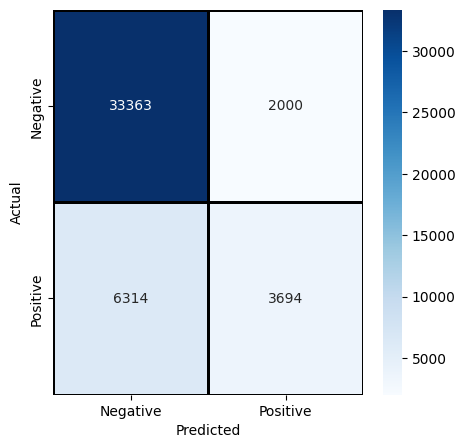

accuracy:   0.817


In [17]:
plot_confusion_matrix_accurancy('sentiment', 'sentiment_calculated')

### Aplicação de um léxico de sentimentos

In [18]:
lex = pd.read_csv("../TM/data/en/NCR-lexicon.csv", encoding="utf-8")
lex.set_index("English", inplace=True)
lex = lex['Positive'] - lex['Negative']
lex = lex.to_dict()

In [19]:
df['bag'] = create_bag_Word_Corpus(df, 'review')

#### Sem tratamento da negação

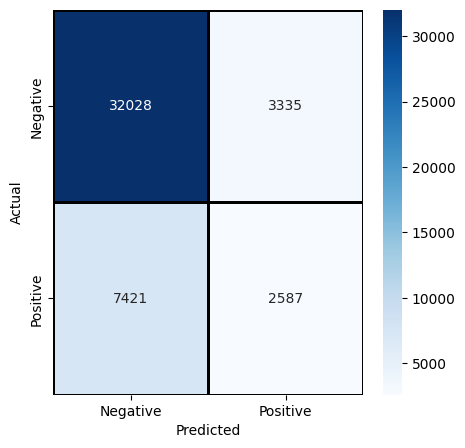

accuracy:   0.763


In [20]:
df['sentiment_lex'] = sentiment_lex(df, 'bag', blindneg=False)
plot_confusion_matrix_accurancy('sentiment', 'sentiment_lex')

#### Com tratamento da negação

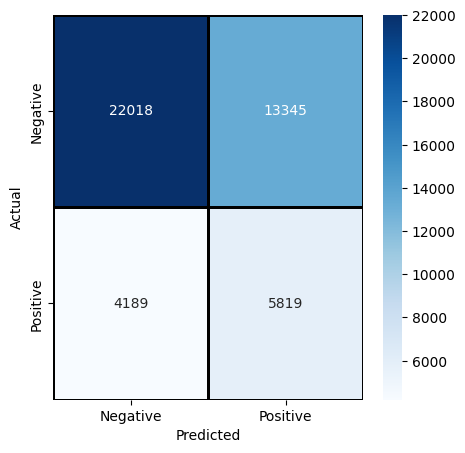

accuracy:   0.614


In [21]:
df['sentiment_lex_bn'] = sentiment_lex(df, 'bag', blindneg=True)
plot_confusion_matrix_accurancy('sentiment', 'sentiment_lex_bn')

### Aprendizagem automática

#### Features:

- Maiúsculas e minúsculas
- Minúsculas
- Normalização de palavras
- Steaming
- Com e sem part-of-speach
- Entidades mencionadas
- GloVe (embeddings)

Possible Improvements
* Filtering
* Part of Speech Tag Filter
* Chunks (Parsing)
* NER

#### Models to test:

- Naive Bayes
- LDA
- LSA
- Chunking
- Coherence Models
- Logistic Regression
- Support Vector Machine (SVM)
- Multinomial Naive Bayes
- Text Classification

### Preparação dos Dados

In [47]:
df['sentiment_to_binary_n'] = df['sentiment'].apply(sentiment_to_binary_n)

In [70]:
tfidf_vectorizer_vectors=tfidf(df,'review')

In [90]:
df.sample(10)

,sentiment,review,sentiment_calculated,bag,sentiment_lex,sentiment_lex_bn,sentiment_to_binary_n
36311,positive,The packaging for Kellogg's new CRUNCHY NUT ce...,positive,"[packag, kellogg, 's, new, crunchi, nut, cerea...",positive,positive,1
44152,positive,"I enjoy this coffee occationally, but the offi...",positive,"[enjoy, coffe, occat, offic, split, right, mid...",positive,positive,1
956,positive,"I like the concept, and I like Asian food, but...",negative,"[like, concept, like, asian, food, ``, roast, ...",positive,negative,1
6242,negative,I was very dissapointed with this fondant. I d...,positive,"[dissapoint, fondant, decid, tri, first, time,...",positive,positive,0
25871,positive,"Seriously good Jerky. There is Cheaper Jerky, ...",positive,"[serious, good, jerki, cheaper, jerki, better,...",positive,positive,1
35064,negative,Hellmans no longer tastes like it used to. I r...,negative,"[hellman, longer, tast, like, use, read, anoth...",positive,positive,0
33270,negative,Very disappointed. Made my cat sick. Total w...,negative,"[disappoint, made, cat, sick, total, wast, mon...",positive,negative,0
44817,positive,If you're out there looking for a tea that can...,positive,"['re, look, tea, rival, coffe, like, black, te...",positive,negative,1
29781,positive,"Being a longtime tea drinker, I was surprised ...",positive,"[longtim, tea, drinker, surpris, found, good, ...",positive,negative,1
14769,negative,So I had a big problem this season with rabbit...,positive,"[big, problem, season, rabbit, eat, hosta, lil...",positive,negative,0


In [91]:
multinomial_nb(df, 'sentiment_to_binary_n', tfidf_vectorizer_vectors)

Pontos rotulados incorretamente: 9121 de 45371
Accuracy:  0.7989685041105552
Precision:  0.882819650959084
Recall:  0.5453175352430778
F1-measure:  0.5263984444083023


In [92]:
logistic_regression(df, 'sentiment_to_binary_n', tfidf_vectorizer_vectors)

Pontos rotulados incorretamente: 4190 de 45371
Accuracy:  0.9076502611800489
Precision:  0.8946049585775343
Recall:  0.8254854392085123
F1-measure:  0.8533950287389855


In [93]:
linear_svc(df, 'sentiment_to_binary_n', tfidf_vectorizer_vectors)

Pontos rotulados incorretamente: 2008 de 45371
Accuracy:  0.9557426549998898
Precision:  0.9453348871454752
Recall:  0.9239310457580829
F1-measure:  0.9340802881172501
